In [ ]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
from river.drift import ADWIN
import numpy as np
import pandas as pd

In [ ]:
np.random.seed(42)

# stable behaviour period
stable = np.random.normal(loc=0.6, scale=0.05, size=200)

# drift: CXO engagement drops
drift = np.random.normal(loc=0.35, scale=0.05, size=200)

stream = np.concatenate([stable, drift])

In [ ]:
adwin = ADWIN(delta=0.002)

In [ ]:
drift_points = []

for i, value in enumerate(stream):
    adwin.update(value)

    if adwin.drift_detected:
        drift_points.append(i)
        print(f"Drift detected at index {i}")

Drift detected at index 255


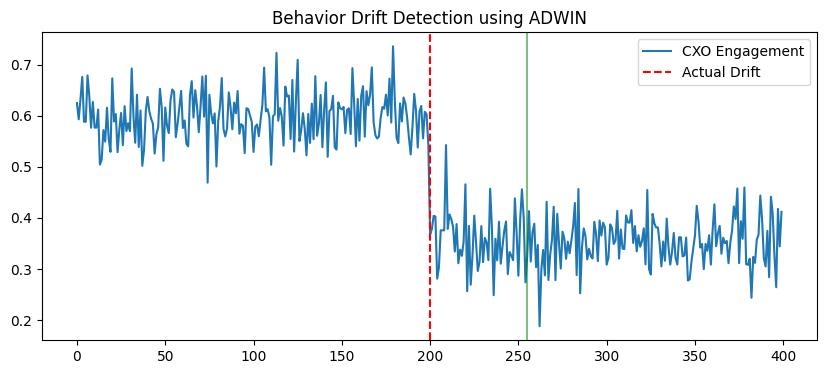

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(stream, label="CXO Engagement")
plt.axvline(x=200, color='red', linestyle='--', label="Actual Drift")

for d in drift_points:
    plt.axvline(x=d, color='green', alpha=0.5)

plt.legend()
plt.title("Behavior Drift Detection using ADWIN")
plt.show()

In [ ]:
true_drift_point = 200

detection_delay = drift_points[0] - true_drift_point
print("Detection Delay:", detection_delay)

Detection Delay: 55


In [ ]:
adwin = ADWIN(delta=0.01)

In [ ]:
drift_points = []

for i, value in enumerate(stream):
    adwin.update(value)
    if adwin.drift_detected:
        drift_points.append(i)

print("Drift detected at:", drift_points[0])
print("Detection delay:", drift_points[0] - 200)

Drift detected at: 255
Detection delay: 55


In [ ]:
smoothed_stream = pd.Series(stream).rolling(5).mean().fillna(method='bfill')

/tmp/ipython-input-2492036597.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_stream = pd.Series(stream).rolling(5).mean().fillna(method='bfill')


In [ ]:
smoothed_stream = pd.Series(stream).rolling(5).mean().fillna(method='bfill')

/tmp/ipython-input-2492036597.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_stream = pd.Series(stream).rolling(5).mean().fillna(method='bfill')


In [ ]:
df = pd.read_excel("/content/OutreachAI_AlgoDataset_Hackathon.xlsx")

In [ ]:
df = df.sort_values('Date')

In [ ]:
df['behavior_score'] = (
    df['Clay_Intent_Signal'] +
    df['Apollo_Engagement_Score'] +
    df['Email_Open_Rate'] +
    df['Cold_Call_Response']
) / 4

In [ ]:
from river.drift import ADWIN

adwin = ADWIN(delta=0.01)

drift_points = []

for i, value in enumerate(df['behavior_score']):
    adwin.update(value)

    if adwin.drift_detected:
        drift_points.append(i)

drift_points[:10]

[]

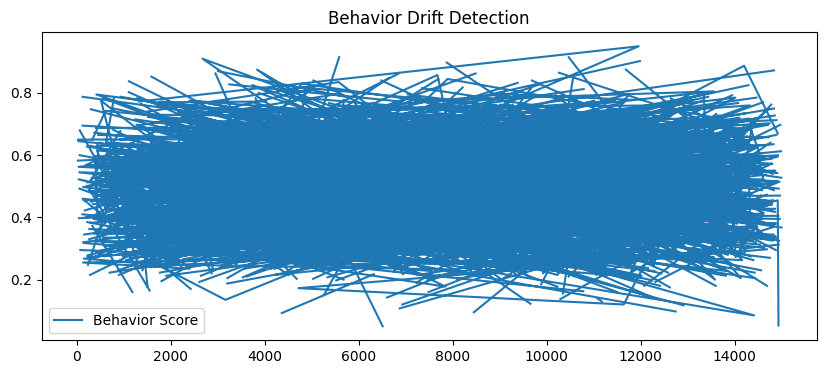

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['behavior_score'], label='Behavior Score')

for d in drift_points:
    plt.axvline(x=d, linestyle='--', alpha=0.5)

plt.title("Behavior Drift Detection")
plt.legend()
plt.show()

In [ ]:
adwin = ADWIN()

email_drift = []

for i, value in enumerate(df['Email_Open_Rate']):
    adwin.update(value)
    if adwin.drift_detected:
        email_drift.append(i)

email_drift

[]

In [ ]:
df = df.sort_values('Clay_Intent_Signal')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
today = df['Date'].max()

df['days_since_activity'] = (today - df['Date']).dt.days

In [ ]:
max_days = 90

df['decay_score'] = df['days_since_activity'] / max_days
df['decay_score'] = df['decay_score'].clip(0,1)

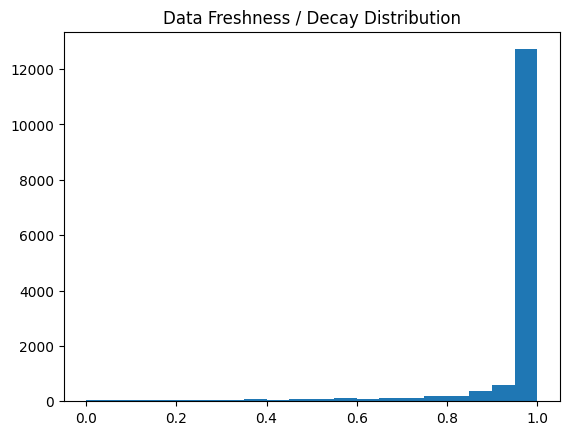

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['decay_score'], bins=20)
plt.title("Data Freshness / Decay Distribution")
plt.show()

In [ ]:
df['fresh_intent'] = df['Clay_Intent_Signal'] * (1 - df['decay_score'])
df['fresh_engagement'] = df['Apollo_Engagement_Score'] * (1 - df['decay_score'])

In [ ]:
stale_leads = df[df['decay_score'] > 0.7]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
today = df['Date'].max()
df['days_since_activity'] = (today - df['Date']).dt.days

In [ ]:
import numpy as np

half_life = 30   # days for engagement relevance to halve

df['decay_score'] = 1 - np.exp(-df['days_since_activity']/half_life)

In [ ]:
df['decay_score'] = df['decay_score'].clip(0,1)

In [ ]:
df[['Date','days_since_activity','decay_score']].head()

,Date,days_since_activity,decay_score
12912,2023-04-21,430,0.999999
8496,2023-11-01,236,0.999617
2360,2023-09-08,290,0.999937
2402,2024-04-24,61,0.869102
7479,2023-04-14,437,1.000000


decay score done